<a href="https://colab.research.google.com/github/Hiba-Rafique/AI_Project/blob/main/wav2vec2RandomForestRegressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
!pip install -q gdown

# Replace with the actual folder ID from the shared link
folder_id = "1QfDRbwC9y3_7kc-oQqQdRizW96A8pU76"

# Download all files in the shared folder to Colab
!gdown --folder "https://drive.google.com/drive/folders/{folder_id}" -O "/content/SongEval_Embeddings"


Retrieving folder contents
Processing file 1aaSmvSnt4oBWdbfCNP5n9VwX1TeYV6sg X_wav2vec2.npy
Processing file 19DcnmDznl8B8nsv2nP4xEtv7gtDY3R44 y_targets.npy
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1aaSmvSnt4oBWdbfCNP5n9VwX1TeYV6sg
To: /content/SongEval_Embeddings/X_wav2vec2.npy
100% 1.47M/1.47M [00:00<00:00, 55.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=19DcnmDznl8B8nsv2nP4xEtv7gtDY3R44
To: /content/SongEval_Embeddings/y_targets.npy
100% 19.3k/19.3k [00:00<00:00, 49.4MB/s]
Download completed


In [ ]:
import numpy as np

X = np.load("/content/SongEval_Embeddings/X_wav2vec2.npy")
y = np.load("/content/SongEval_Embeddings/y_targets.npy", allow_pickle=True)

print("✅ Loaded embeddings and targets:")
print("X shape:", X.shape)
print("y shape:", y.shape)


✅ Loaded embeddings and targets:
X shape: (480, 768)
y shape: (480, 5)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")


Train samples: 384, Test samples: 96


# Initialize Random Forest

In [ ]:

rf = RandomForestRegressor(
    n_estimators=100,   # number of trees
    max_depth=None,     # expand fully; reduce if RAM issues
    n_jobs=-1,          # use all CPU cores
    random_state=42
)

# Wrap in MultiOutputRegressor for multiple targets
multi_rf = MultiOutputRegressor(rf)
print("Training Random Forest... (this may take a minute)")
multi_rf.fit(X_train, y_train)

Training Random Forest... (this may take a minute)


MultiOutputRegressor(estimator=RandomForestRegressor(n_jobs=-1,
                                                     random_state=42))

In [ ]:

y_pred = multi_rf.predict(X_test)

# Evaluate

In [ ]:

target_names = ["Coherence", "Musicality", "Memorability", "Clarity", "Naturalness"]
for i, target in enumerate(target_names):
    mse = mean_squared_error(y_test[:, i], y_pred[:, i])
    r2 = r2_score(y_test[:, i], y_pred[:, i])
    print(f"{target:12s} | MSE: {mse:.4f} | R²: {r2:.4f}")


Coherence    | MSE: 0.4647 | R²: 0.6463
Musicality   | MSE: 0.5123 | R²: 0.6081
Memorability | MSE: 0.6092 | R²: 0.6063
Clarity      | MSE: 0.5065 | R²: 0.6080
Naturalness  | MSE: 0.4474 | R²: 0.6393


# plot predicted vs actual

NameError: name 'target_names' is not defined

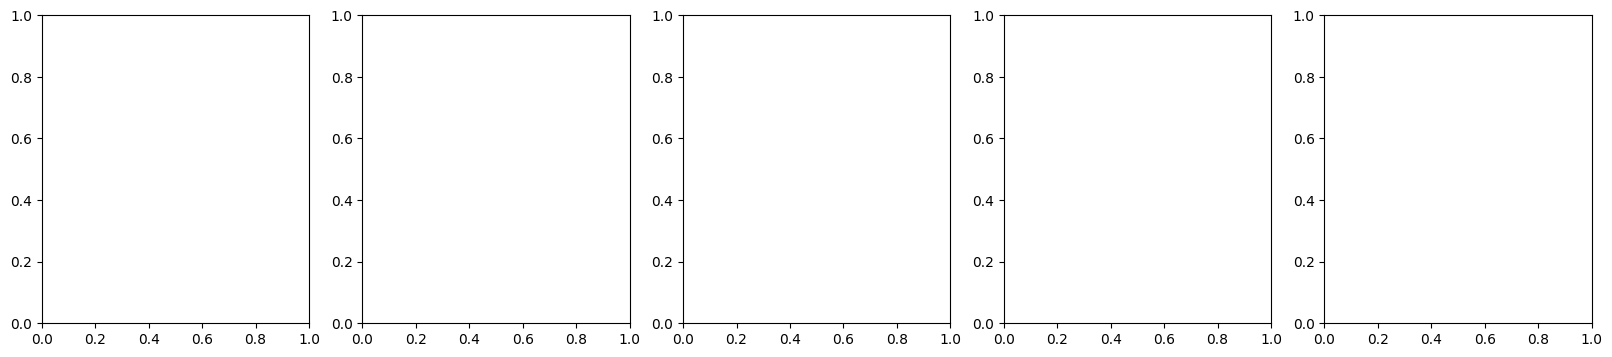

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages("Predicted_vs_Actual_AllTargets.pdf") as pdf:
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    axes = axes.flatten()

    for i, target in enumerate(target_names):
        ax = axes[i]
        sns.scatterplot(x=y_test[:, i], y=y_pred[:, i], ax=ax, s=50, color="royalblue", alpha=0.6)
        min_val = min(y_test[:, i].min(), y_pred[:, i].min())
        max_val = max(y_test[:, i].max(), y_pred[:, i].max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
        ax.set_title(target)
        ax.set_xlabel("Actual")
        ax.set_ylabel("Predicted")
        ax.grid(True)

    plt.tight_layout()
    pdf.savefig(fig, bbox_inches='tight')  # save the figure to the PDF
    plt.close()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
import os
import joblib
save_dir = "/content/drive/MyDrive/SongEval_Models"
os.makedirs(save_dir, exist_ok=True)
model_path = os.path.join(save_dir, "random_forest_wav2vec2.pkl")
joblib.dump(multi_rf, model_path)
print(f"✅ Model saved to: {model_path}")


# Evaluate performance with multiple metrics

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
target_names = ["Coherence", "Musicality", "Memorability", "Clarity", "Naturalness"]

for i, target in enumerate(target_names):
    y_true = y_test[:, i]
    y_pred_target = y_pred[:, i]

    mse = mean_squared_error(y_true, y_pred_target)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred_target)
    r2 = r2_score(y_true, y_pred_target)

    print(f"{target:12s} | MSE: {mse:.4f} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")


In [ ]:
import pandas as pd

metrics_df = pd.DataFrame({
    "Target": target_names,
    "MSE": [mean_squared_error(y_test[:, i], y_pred[:, i]) for i in range(len(target_names))],
    "RMSE": [np.sqrt(mean_squared_error(y_test[:, i], y_pred[:, i])) for i in range(len(target_names))],
    "MAE": [mean_absolute_error(y_test[:, i], y_pred[:, i]) for i in range(len(target_names))],
    "R2": [r2_score(y_test[:, i], y_pred[:, i]) for i in range(len(target_names))]
})

print("\n✅ Evaluation summary:")
print(metrics_df)

In [ ]:
import numpy as np
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.metrics import accuracy_score

# Target names in order
target_names = ["Coherence", "Musicality", "Memorability", "Clarity", "Naturalness"]

print("🔍 Computing evaluation metrics...")

num_targets = y_test.shape[1]

pearson_scores = []
spearman_scores = []
kendall_scores = []

for i in range(num_targets):
    y_true = y_test[:, i]
    y_pred_i = y_pred[:, i]

    # Pearson (Linear Correlation)
    p, _ = pearsonr(y_true, y_pred_i)
    pearson_scores.append(p)

    # Spearman Rank Correlation
    s, _ = spearmanr(y_true, y_pred_i)
    spearman_scores.append(s)

    # Kendall Rank Correlation
    k, _ = kendalltau(y_true, y_pred_i)
    kendall_scores.append(k)


# ─────────────────────────────────────────────
# 📌 Print per-target metrics with names
# ─────────────────────────────────────────────
print("\n📌 **Correlation Metrics per Target**")
for i, name in enumerate(target_names):
    print(f"\n🎼 {name}:")
    print(f"  Pearson  r  = {pearson_scores[i]:.4f}")
    print(f"  Spearman ρ = {spearman_scores[i]:.4f}")
    print(f"  Kendall τ  = {kendall_scores[i]:.4f}")


# ─────────────────────────────────────────────
# 📌 Mean metrics across all targets
# ─────────────────────────────────────────────
print("\n📌 **Mean Correlation Across All Targets**")
print(f"Mean Pearson  r  = {np.mean(pearson_scores):.4f}")
print(f"Mean Spearman ρ = {np.mean(spearman_scores):.4f}")
print(f"Mean Kendall τ  = {np.mean(kendall_scores):.4f}")


In [ ]:
# Top-tier accuracy
true_top = np.argmax(y_test, axis=1)
pred_top = np.argmax(y_pred, axis=1)

top_tier_acc = accuracy_score(true_top, pred_top)

print("\n🎯 Top-tier Accuracy:")
print(f"Top-tier Accuracy = {top_tier_acc:.4f}")


In [ ]:
import pandas as pd

results_df = pd.DataFrame({
    "Target": target_names,
    "Pearson_r": pearson_scores,
    "Spearman_rho": spearman_scores,
    "Kendall_tau": kendall_scores
})

print("\n📊 Summary Table:")
results_df


In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
from google.colab import files

# Ensure inline backend (usually default in Colab)
%matplotlib inline

# Capture all currently open figures
all_figs = plt.get_fignums()  # list of figure numbers

if not all_figs:
    print("No open figures found! Make sure your plots are still active.")
else:
    pdf_filename = "all_generated_plots.pdf"
    with PdfPages(pdf_filename) as pdf:
        for num in all_figs:
            fig = plt.figure(num)
            pdf.savefig(fig)
            plt.close(fig)  # free memory

    print(f"Saved {len(all_figs)} plots to {pdf_filename}")
    files.download(pdf_filename)
